In [1]:
!pip install pykeops[full] > install.log


ERROR: breathe 4.26.1 has requirement Sphinx<3.5,>=3.0, but you'll have sphinx 1.8.5 which is incompatible.


Nystrom implementation

In [2]:
from sklearn import datasets, svm
#from sklearn.kernel_approximation import Nystroem
import time
import numpy as np
import torch
from matplotlib import pyplot as plt
from pykeops.torch import LazyTensor
from scipy.linalg import svd

In [3]:
def pairwise_kernels_keops(x,y=None, sigma=0.1):
  """A kernel matrix K such that K_{i, j} is the kernel between the ith and jth 
  vectors of the given matrix X"""
  #TODO: check pairwise arrays etc for Value Error
  if y==None:
    y=x
  x_i = LazyTensor(x[:, None, :])  # (M, 1, 1)
  y_j = LazyTensor(y[None, :, :])  # (1, N, 1)
  print(123)
  D_ij = ((x_i - y_j) ** 2).sum(-1)  # (M, N) symbolic matrix of squared distances
  print(type(D_ij))
  return (-D_ij / (2 * sigma ** 2)).exp()  # (M, N) symbolic Gaussian kernel matrix
  


def pairwise_kernels(x, y=None, sigma =0.1):
  if y==None:
    y=x
  x_i = x[:, None, :]  # (M, 1, 1)
  y_j = y[None, :, :] # (1, N, 1)
  D_ij = ((x_i-y_j) ** 2).sum(-1)  # (M, N) symbolic matrix of squared distances
  print(type(D_ij))
  return (-D_ij / (2 * sigma ** 2)).exp()  # (M, N) symbolic Gaussian kernel matrix
    



In [4]:
#generate data
use_cuda = torch.cuda.is_available()
dtype = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor

N = 10000 if use_cuda else 1000  # Number of samples

# Sampling locations:
x = torch.rand(N, 1).type(dtype)

# Some random-ish 1D signal:
b = (
    x
    + 0.5 * (6 * x).sin()
    + 0.1 * (20 * x).sin()
    + 0.05 * torch.randn(N, 1).type(dtype)
)

In [7]:
class Nystrom:
  def __init__(self, n_components=100):
    self.n_components = n_components
    #self.normalization_=None

  def fit(self, X, y):
    #number of samples. must be greater than n_components
    n_samples = X.shape[0]

    #define basis
    n_components = min(n_samples, self.n_components) #should be = n_samples
    inds = torch.randperm(n_samples) #rnd.permutation(n_samples)
    basis_inds = inds[:n_components]
    basis = X[basis_inds]
    #print(basis.shape)
    # get rbf kernel matrix
    basis_kernel = pairwise_kernels(basis, y)

    #get svd
    #basis_kernel_torch = torch.LazyTensor(basis_kernel)
    U, S, V = torch.svd(basis_kernel) # svd(basis_kernel.numpy())
    #S = torch.maximum(S, torch.constant(1e-12))
    #print(U.shape,S.shape, V.shape)
    u = U * 1. / torch.sqrt(S)
    self.normalization_ = torch.dot(u[:,0], V[:,0]) #????
    self.components_ = basis
    self.component_indices_ = inds
    print(self.normalization_)
    return basis_kernel




In [8]:
#print(x)
feature_map_nystrom = Nystrom()
#feature_map_nystrom.fit(x)


In [10]:
from matplotlib import pyplot as plt
t = torch.linspace(0, 1, 1001).type(dtype)[:, None]
alpha = 1.0  # Ridge regularization
K_xx = feature_map_nystrom.fit(x,x)
print(K_xx.shape)
a = K_xx.solve(b, x)
K_tx = feature_map_nystrom.fit(t,x)
mean_t = K_tx @ a

# 1D plot:
plt.figure(figsize=(8, 6))

plt.scatter(x.cpu()[:, 0], b.cpu()[:, 0], s=100 / len(x))  # Noisy samples
plt.plot(t.cpu().numpy(), mean_t.cpu().numpy(), "r")

plt.axis([0, 1, 0, 1])
plt.tight_layout()

<class 'torch.Tensor'>
torch.Size([100, 1000])


TypeError: ignored

In [ ]:
X = torch.randn(1000000, 3, requires_grad=True).cuda()
y = torch.randn(2000000, 3).cuda()
data = X 

clf = svm.LinearSVC()
feature_map_nystroem = Nystroem(gamma=.2,
                                random_state=1,
                                n_components=300)

data_transformed = feature_map_nystroem.fit_transform(data)

SKLearn nystroem example

In [ ]:
type(X)

numpy.ndarray

(1797, 64)


<Figure size 432x288 with 0 Axes>

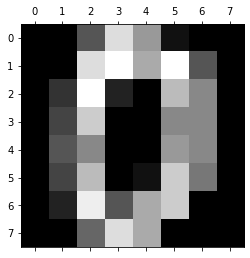

In [ ]:
from sklearn.datasets import load_digits
digits = load_digits()
print(digits.data.shape)

import matplotlib.pyplot as plt 
plt.gray() 
plt.matshow(digits.images[0]) 
plt.show() 

In [ ]:
%%timeit
clf.fit(data_transformed, y)


10 loops, best of 3: 150 ms per loop


In [ ]:
data_transformed.shape

(1617, 300)

In [ ]:
%%timeit
clf.score(data_transformed, y)

The slowest run took 4.38 times longer than the fastest. This could mean that an intermediate result is being cached.
100 loops, best of 3: 2.28 ms per loop


Nyst

In [ ]:
def gaussian_kernel(x, y, sigma=0.1):
  print(x)
  print(123)
  x= torch.tensor(x)
  x_i = LazyTensor(x[:, None, :])  # (M, 1, 1)
  y_j = LazyTensor(y[None, :, :])  # (1, N, 1)
  print(123)
  D_ij = ((x_i - y_j) ** 2).sum(-1)  # (M, N) symbolic matrix of squared distances
  print(type(D_ij))
  return (-D_ij / (2 * sigma ** 2)).exp()  # (M, N) symbolic Gaussian kernel matrix

In [ ]:
class Nystroem_keops(Nystroem):
  def __init__(self, kernel="rbf", gamma=None, coef0=1, degree=3,
                 kernel_params=None, n_components=100, random_state=None):
    
    super().__init__( kernel="rbf", gamma=None, coef0=1, degree=3,
                 kernel_params=None, n_components=100, random_state=None)
    
  def pairwise_kernels(X,y, metric="rbf",
                                    filter_params=True,
                                    **kernel_params):
    
    alpha = 1.0  # Ridge regularization

    K_xx = gaussian_kernel(X,X)
    #a = K_xx.solve(y, alpha=alpha)

    return K_xx
    

In [ ]:
print(feature_map_nystroem_keops.pairwise_kernels(X,y))

Nystroem_keops(coef0=1, degree=3, gamma=None, kernel='rbf', kernel_params=None,
               n_components=100, random_state=None)
123


RuntimeError: ignored

In [ ]:
clf = svm.LinearSVC()
feature_map_nystroem_keops = Nystroem_keops(gamma=.2,
                                random_state=1,
                                n_components=300)
data_transformed_keops = feature_map_nystroem_keops.fit_transform(data)

In [ ]:
%%timeit
clf.fit(data_transformed_keops, y)

10 loops, best of 3: 87.1 ms per loop


In [ ]:
%%timeit
clf.score(data_transformed_keops, y)

1000 loops, best of 3: 1.22 ms per loop


In [39]:
use_cuda = torch.cuda.is_available()
dtype = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor

N = 10000 if use_cuda else 1000  # Number of samples

# Sampling locations:
x = torch.rand(N, 1).type(dtype)

# Some random-ish 1D signal:
y = (
    x
    + 0.5 * (6 * x).sin()
    + 0.1 * (20 * x).sin()
    + 0.05 * torch.randn(N, 1).type(dtype)
)

In [40]:
def gaussian_kernel(x, y, sigma=0.1):
    x_i = LazyTensor(x[:, None, :])  # (M, 1, 1)
    y_j = LazyTensor(y[None, :, :])  # (1, N, 1)
    D_ij = ((x_i - y_j) ** 2).sum(-1)  # (M, N) symbolic matrix of squared distances
    return (-D_ij / (2 * sigma ** 2)).exp()  # (M, N) symbolic Gaussian kernel matrix

In [43]:
alpha = 1.0  # Ridge regularization

start = time.time()

K_xx = gaussian_kernel(x, x)
print(K_xx)
a = K_xx.solve(b, alpha=alpha)

end = time.time()

print(
    "Time to perform an RBF interpolation with {:,} samples in 1D: {:.5f}s".format(
        N, end - start
    )
)

KeOps LazyTensor
    formula: Exp((Minus(Sum(Square((Var(0,1,0) - Var(1,1,1))))) / Var(2,1,2)))
    shape: (10000, 10000)
Time to perform an RBF interpolation with 10,000 samples in 1D: 0.06195s


In [ ]:
# Extrapolate on a uniform sample:
t = torch.linspace(0, 1, 1001).type(dtype)[:, None]

K_tx = gaussian_kernel(t, x)
mean_t = K_tx @ a

# 1D plot:
plt.figure(figsize=(8, 6))

plt.scatter(x.cpu()[:, 0], b.cpu()[:, 0], s=100 / len(x))  # Noisy samples
plt.plot(t.cpu().numpy(), mean_t.cpu().numpy(), "r")

plt.axis([0, 1, 0, 1])
plt.tight_layout()

In [ ]:
# Sampling locations:
x = torch.rand(N, 2).type(dtype)

# Some random-ish 2D signal:
b = ((x - 0.5) ** 2).sum(1, keepdim=True)
b[b > 0.4 ** 2] = 0
b[b < 0.3 ** 2] = 0
b[b >= 0.3 ** 2] = 1
b = b + 0.05 * torch.randn(N, 1).type(dtype)

# Add 25% of outliers:
Nout = N // 4
b[-Nout:] = torch.rand(Nout, 1).type(dtype)

In [ ]:
def laplacian_kernel(x, y, sigma=0.1):
    x_i = LazyTensor(x[:, None, :])  # (M, 1, 1)
    y_j = LazyTensor(y[None, :, :])  # (1, N, 1)
    D_ij = ((x_i - y_j) ** 2).sum(-1)  # (M, N) symbolic matrix of squared distances
    return (-D_ij.sqrt() / sigma).exp()  # (M, N) symbolic Laplacian kernel matrix

In [ ]:
alpha = 10  # Ridge regularization

start = time.time()

K_xx = laplacian_kernel(x, x)
a = K_xx.solve(b, alpha=alpha)

end = time.time()

print(
    "Time to perform an RBF interpolation with {:,} samples in 2D: {:.5f}s".format(
        N, end - start
    )
)

Compiling libKeOpstorch224a96a9e0 in /root/.cache/pykeops-1.4.2-cpython-36:
       formula: Sum_Reduction((Exp((Minus(Sqrt(Sum(Square((Var(1,1,0) - Var(2,1,1)))))) / Var(3,1,2))) * Var(0,1,1)),0)
       aliases: Var(0,1,1); Var(1,1,0); Var(2,1,1); Var(3,1,2); 
       dtype  : float32
... Done.
Time to perform an RBF interpolation with 1,000 samples in 2D: 33.21815s


In [ ]:
# Extrapolate on a uniform sample:
X = Y = torch.linspace(0, 1, 101).type(dtype)
X, Y = torch.meshgrid(X, Y)
t = torch.stack((X.contiguous().view(-1), Y.contiguous().view(-1)), dim=1)

K_tx = laplacian_kernel(t, x)
mean_t = K_tx @ a
mean_t = mean_t.view(101, 101)

# 2D plot: noisy samples and interpolation in the background
plt.figure(figsize=(8, 8))

plt.scatter(
    x.cpu()[:, 0], x.cpu()[:, 1], c=b.cpu().view(-1), s=25000 / len(x), cmap="bwr"
)
plt.imshow(
    mean_t.cpu().numpy()[::-1, :],
    interpolation="bilinear",
    extent=[0, 1, 0, 1],
    cmap="coolwarm",
)

# sphinx_gallery_thumbnail_number = 2
plt.axis([0, 1, 0, 1])
plt.tight_layout()
plt.show()

Compiling libKeOpstorch55e6750531 in /root/.cache/pykeops-1.4.2-cpython-36:
       formula: Sum_Reduction((Exp((Minus(Sqrt(Sum(Square((Var(0,2,0) - Var(1,1,1)))))) / Var(2,1,2))) * Var(3,1,1)),0)
       aliases: Var(0,2,0); Var(1,1,1); Var(2,1,2); Var(3,1,1); 
       dtype  : float32
... Done.


IndexError: ignored

<Figure size 576x576 with 0 Axes>